In [7]:
import numpy as np
import pandas as pd
from scipy.io import loadmat, mmread
import sys
import itertools 
import pickle
import matplotlib.pylab as plt
import time

In [8]:
%matplotlib inline

In [9]:
import rankingmethod
import rankingmeasure
import rank

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
from  experiment import *

# loading data sets

In [7]:
data = pd.read_csv("../datasets/soc-Epinions1.txt", sep='\t', header=4)
data = data.as_matrix()

In [8]:
epinion, epinion_shape = make_valid_data(data)

In [8]:
data = pd.read_csv("../datasets/Slashdot0811.txt", sep='\t', header=4)
data = data.as_matrix()

In [15]:
slashdot, slashdot_shape = make_valid_data(data)

In [12]:
data =  pd.read_csv("../datasets/ml-100k/u.data", sep='\t', header=None).ix[:, :1]
data = data.as_matrix()

In [13]:
ml100k, ml100k_shape = make_valid_data(data)

In [ ]:
data = pd.read_csv("../datasets/ml-1m/ratings.dat", sep='::', header=None,  engine='python').ix[:, :1]
data = data.as_matrix()

In [19]:
ml1m, ml1m_shape = make_valid_data(data)

### Узнаем статистические данные о датасетам.

In [65]:
def statistics_of_data(matrix):
    num_nonzero = matrix.shape[0]
    num_user = np.unique(matrix[:, 0]).shape[0]
    num_items = np.unique(matrix[:, 1]).shape[0]
    sparsity = num_nonzero / (num_user * num_items) * 100
    mean_items = np.mean(np.bincount(matrix[:, 0]))
    median_items = np.median(np.bincount(matrix[:, 0]))
    max_items = np.max(np.bincount(matrix[:, 0]))
    return (num_nonzero, num_user, num_items, sparsity, mean_items, median_items, max_items)

In [66]:
print("epinion", statistics_of_data(epinion))
print("slashdot", statistics_of_data(slashdot))
print("ml100k", statistics_of_data(ml100k))
print("ml1m", statistics_of_data(ml1m))

epinion (326114, 4405, 34777, 0.21287831073657335, 74.032690124858121, 51.0, 1801)
slashdot (573578, 6992, 63730, 0.12872033080059936, 82.033466819221971, 50.0, 2508)
ml100k (96963, 806, 1682, 7.152288277868424, 120.3014888337469, 81.0, 737)
ml1m (989202, 5549, 3702, 4.815416389070059, 178.26671472337358, 106.0, 2314)


### Зададим параметры, которые были выбраны при помощивалидации

In [84]:
def create_list_cf(user_item):
    list_cf = [
        rankingmethod.PopRec(user_item),
#         rankingmethod.CLiMF(user_item, K=10, reg=0.001, lrate=0.01, verbose=0, maxiter=10),
        
#         rank.CLiMF(user_item, K=5, reg=0.01, lrate=0.1, verbose=0, maxiter=10),
#         rank.CLiMF(user_item, K=5, reg=0.01, lrate=0.01, verbose=0, maxiter=10),
        rank.CLiMF(user_item, K=5, reg=0.01, lrate=0.001, verbose=0, maxiter=10),
#         rank.CLiMF(user_item, K=15, reg=0.001, lrate=0.1, verbose=0, maxiter=10),
        rank.BPR_MF(user_item, K = 20, lrate=0.012, regIpos=0.012, 
                                  regIneg=0.012, regU=0.012, maxiter=20, verbose=0 ),
        
#         rank.CLiMF(user_item, K=10, reg=0.001, lrate=0.1, verbose=0, maxiter=10),
#         rank.CLiMF(user_item, K=10, reg=0.001, lrate=0.001, verbose=0, maxiter=10),
#         rankingmethod.BPR_MF(user_item, K = 20, lrate=0.012, regIpos=0.012, 
#                                   regIneg=0.012, regU=0.012, maxiter=4, verbose=0 ),
        rankingmethod.iMF(user_item, K=10, lmbd=0.01, alpha=40, maxiter=30, verbose=0),
        rankingmethod.TFMAP(user_item, lrate=0.01, maxiter=10),
#         rank.TFMAP(user_item, lrate=0.01, maxiter=20)
    ]
    return list_cf#[list_cf[i] for i in index]

### Проведение такого же эксперимента, как у создатей CLiMF(Точнее похожего, т.к. было решено не удалять топ 3 всех предметов. И даже с этим удалением получить такие же цифры, что авторы epinion не получилось)

In [91]:
def climf_experiment(data, list_cf, K=5, maxiter=1, topK=5, verbose=0, validation_type=1):
    res = np.zeros((6, len(list_cf)))
    for t in range(maxiter):
        if validation_type == 0:
            test, train, traintest = givenK_train_test(data, K)
        elif validation_type == 1:
            test, train, traintest = ratio_train_test(data, K)
        for i, cf in enumerate(list_cf):
            start_time = time.time()
            cf.fit(train)
#             print(time.time() - start_time)
            prec_k, one_recal_k, ngdc, mp = rankingmeasure.get_Kmetrics(train, test, cf, K=topK)
            mrr, auc = rankingmeasure.get_listmetrics(train, test, cf)
            res[:, i] += np.array([prec_k, one_recal_k, ngdc, mp, mrr, auc])
            if verbose == 1:
                print(t, i, res[:, i] / (t + 1))
                sys.stdout.flush()
    res /= maxiter
    res = pd.DataFrame(res)
    
    res.columns = [type(cf).__name__ for cf in list_cf]
    res.index = [name + str(topK) for name in ['prec@', '1recal@', 'NDCG@', 'MAP@']] + ['MRR', 'AUC']
#     res.columns = ['PopRec', 'CLiMF', 'BRP_MP', 'iMF', 'TFMAP']
#     res.index = ['prec@' + str(topK),'1recal@' + str(topK), 'NDCG@' + str(topK), 
#                'MAP@' + str(topK), 'MRR', 'AUC']
    return res

In [93]:
climf_experiment(ml100k, create_list_cf(ml100k_shape), K =0.1, maxiter=5, topK=5,  verbose=0)

KeyboardInterrupt: 

In [ ]:
climf_experiment(ml100k, create_list_cf(ml100k_shape), K =0.2, maxiter=5, topK=5,  verbose=0)

In [ ]:
climf_experiment(epinion, create_list_cf(epinion_shape), K =0.1, maxiter=3, topK=5,  verbose=0)

In [ ]:
climf_experiment(epinion, create_list_cf(epinion_shape), K =0.2, maxiter=3, topK=5,  verbose=1)

In [ ]:
climf_experiment(slashdot, create_list_cf(slashdot_shape), K=0.1, maxiter=3, topK=5,  verbose=0)

In [ ]:
climf_experiment(slashdot, create_list_cf(slashdot_shape), K=0.2, maxiter=3, topK=5,  verbose=0)

In [ ]:
climf_experiment(ml1m, create_list_cf(ml1m_shape), K=0.1, maxiter=3, topK=5, verbose=0)

In [ ]:
climf_experiment(ml1m, create_list_cf(ml1m_shape), K=0.2, maxiter=3, topK=5, verbose=0)

### Построение ансамбля

# Netflix ensemble
# Regression

In [ ]:
from sklearn import cross_validation
import rankensemble
import rankingmeasure

In [ ]:
def netflix_ensemble_experiment(data, list_cf, list_ensemble, Ktrain=0.1, Kvalidation=0.1, 
                                     maxiter=1, topK=5,  verbose=0):
    res = np.zeros((4, len(list_cf) + len(list_ensemble)))
    for t in range(maxiter):
        test, train, traintest = ratio_train_test(data, Ktrain + Kvalidation)
        validation, train, trainvalidation = ratio_train_test(train, Kvalidation, data_is_xlist=True)
        
        for i in range(len(list_cf)):
            list_cf[i].fit(train)
            prec_k, one_recal_k, ngdc, mp = rankingmeasure.get_Kmetrics(trainvalidation, test, list_cf[i], K=topK)
            res[:, i] += np.array([prec_k, one_recal_k, ngdc, mp])
            if verbose == 1:
                print(t, i, res[:, i] / (t + 1))
                sys.stdout.flush()
        for j, ens in enumerate(list_ensemble):
            m = j + len(list_cf)
            ens.fit(list_cf, validation, train, trainvalidation)
#             return X, y
            prec_k, one_recal_k, ngdc, mp = rankingmeasure.get_Kmetrics(trainvalidation, test, ens, K=topK)
            res[:, m] += np.array([prec_k, one_recal_k, ngdc, mp])
            if verbose == 1:
                print(t,  m, res[:, m] / (t + 1))
#         for j, ens in enumerate(list_ensemble):
#             m = j + len(list_cf)
#             ens.fit(list_cf)
#             prec_k, one_recal_k, ngdc, mp = rankingmeasure.get_Kmetrics(train, test, ens, K=topK)
#             res[:, m] += np.array([prec_k, one_recal_k, ngdc, mp])
#             if verbose == 1:
#                 print(t, m, res[:, m] / (t +1))
        
    res /= maxiter
    res[:, len(list_cf) - 1] = np.max(res[:, :len(list_cf)], axis=1)
    res = res[:, len(list_cf)- 1:]
    res = pd.DataFrame(res)
    res.columns = ["best_result"] + [type(ens).__name__ for ens  in list_ensemble]
    res.index = [name + str(topK) for name in ['prec@', '1recal@', 'NDCG@', 'MAP@']]
#     res.index = []
#     res.columns = ['PopRec', 'CLiMF', 'BRP_MP', 'iMF', 'TFMAP', 'top_ensemble', 'rating_ensamble']
#     res.index = ['prec@' + str(topK),'1recal@' + str(topK), 'NDCG@' + str(topK), 
#                'MAP@' + str(topK)]
    return res

In [ ]:
from sklearn import linear_model
import rankensemble
from sklearn import ensemble
from sklearn.kernel_ridge import KernelRidge

In [ ]:
import copy

In [ ]:
list_ensemble = [
    rankensemble.regression_ensemble(linear_model.Ridge(alpha=100)),
    rankensemble.inner_value_ensemble(),
    rankensemble.boost_val_ens(rankingmeasure.get_NDCG,[3,0,1,2], num_weights=11),
    rankensemble.tree_val_ens(rankingmeasure.get_NDCG, [[3, 0],[1,2]], num_weights=11)
]

In [ ]:
netflix_ensemble_experiment(ml100k, create_list_cf(ml100k_shape)[1:5], list_ensemble, Ktrain=0.1, Kvalidation=0.1, verbose=0, maxiter=5)

In [ ]:
netflix_ensemble_experiment(ml100k, create_list_cf(ml100k_shape)[1:5], list_ensemble, Ktrain=0.2, Kvalidation=0.1, verbose=1, maxiter=5)

In [ ]:
netflix_ensemble_experiment(epinion, create_list_cf(epinion_shape)[1:5], list_ensemble, Ktrain=0.1, Kvalidation=0.1, verbose=0, maxiter=3)

In [ ]:
netflix_ensemble_experiment(epinion, create_list_cf(epinion_shape)[1:5], list_ensemble, Ktrain=0.2, Kvalidation=0.1, verbose=0, maxiter=3)

In [ ]:
netflix_ensemble_experiment(ml1m, create_list_cf(ml1m_shape)[1:5], list_ensemble, Ktrain=0.1, Kvalidation=0.1, verbose=0, maxiter=3)

In [ ]:
netflix_ensemble_experiment(ml1m, create_list_cf(ml1m_shape)[1:5], list_ensemble, Ktrain=0.2, Kvalidation=0.1, verbose=0, maxiter=3)

In [ ]:
netflix_ensemble_experiment(slashdot, create_list_cf(slashdot_shape)[1:5], list_ensemble, Ktrain=0.1, Kvalidation=0.1, verbose=0, maxiter=3)

In [303]:
netflix_ensemble_experiment(slashdot, create_list_cf(slashdot_shape)[1:5], list_ensemble, Ktrain=0.2, Kvalidation=0.1, verbose=0, maxiter=3)

,CLiMF,BPR_MF,iMF,TFMAP,inner_value_ensemble
prec@5,0.099838,0.098989,0.123999,0.099580,0.111108
1recal@5,0.325181,0.321892,0.371568,0.328852,0.356550
NDCG@5,0.108849,0.108185,0.130403,0.108039,0.117573
MAP@5,0.197878,0.196931,0.222450,0.197167,0.207369


In [151]:
alpha = find_alpha(t1, t2)

(25, 4) [[1 1 1 1]
 [2 3 1 1]
 [3 5 1 1]
 [4 4 1 1]
 [5 2 1 1]
 [1 1 2 3]
 [2 3 2 3]
 [3 5 2 3]
 [4 4 2 3]
 [5 2 2 3]
 [1 1 3 5]
 [2 3 3 5]
 [3 5 3 5]
 [4 4 3 5]
 [5 2 3 5]
 [1 1 4 4]
 [2 3 4 4]
 [3 5 4 4]
 [4 4 4 4]
 [5 2 4 4]
 [1 1 5 2]
 [2 3 5 2]
 [3 5 5 2]
 [4 4 5 2]
 [5 2 5 2]]


In [152]:
alpha

array([ 0.25      ,  0.5       ,  0.6       ,  0.66666667])

In [153]:
i = 0.66666667
t1 * i + t2 * (1 - i)

array([ 1.        ,  2.33333333,  3.66666666,  4.        ,  4.00000001])

In [102]:
np.sort(alpha)

array([ 0.5])

In [101]:
netflix_ensemble_experiment(epinion, create_list_cf(epinion_shape)[1:5], list_ensemble, Ktrain=5, Kvalidation=5, verbose=1)

NameError: name 'netflix_ensemble_experiment' is not defined

In [90]:
a = np.arange(4 * 5).reshape(4, 5).astype(float)
a += 1
print(a)
a  /=  np.max(a , axis=0)[np.newaxis, :]
print(a)

[[  1.   2.   3.   4.   5.]
 [  6.   7.   8.   9.  10.]
 [ 11.  12.  13.  14.  15.]
 [ 16.  17.  18.  19.  20.]]
[[ 0.0625      0.11764706  0.16666667  0.21052632  0.25      ]
 [ 0.375       0.41176471  0.44444444  0.47368421  0.5       ]
 [ 0.6875      0.70588235  0.72222222  0.73684211  0.75      ]
 [ 1.          1.          1.          1.          1.        ]]


In [86]:
np.max(a , axis=0)

array([16, 17, 18, 19, 20])

In [25]:
create_list_cf

NameError: name 'list_cf' is not defined

In [ ]:
givenK_train_test()

In [139]:
kf = cross_validation.KFold(n=10, n_folds=2, shuffle=True,
                               random_state=None)

for train_index, test_index in kf:
    print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

TRAIN: [0 2 4 7 9] TEST: [1 3 5 6 8]
TRAIN: [1 3 5 6 8] TEST: [0 2 4 7 9]


In [ ]:
def rank_cross_validation(train, test, train_index, test_index):
    x_train = [train[i] for i in train_index]
    x_test = [train[i] for i in test_index]
    
    y_train = [test[i] for i in train_index]
    y_test = [test[i] for i in test_index]
    
    return X_train, X_test, y_train, y_test

## Старые некрасивые эксперименты

### проверка работы ансамбля givenk = 5

In [34]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.20889898,  0.59659478,  0.23334799,  0.40400019])

In [36]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.19704881  0.55913734  0.22254752  0.38464813]
[ 0.1938252   0.56118048  0.22009766  0.38748802]
[ 0.19523269  0.56072645  0.22107609  0.38591121]
[ 0.17711691  0.52485812  0.18861426  0.32164586]
[ 0.18719637  0.55323496  0.21465356  0.38445958]


In [37]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 10)

array([ 0.17402951,  0.72122588,  0.20026969,  0.37375175])

In [38]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 10))

[ 0.16944381  0.68876277  0.19412473  0.35670129]
[ 0.16989784  0.68944381  0.19419015  0.3561263 ]
[ 0.16955732  0.69057889  0.19406199  0.35569465]
[ 0.15768445  0.67309875  0.17098093  0.31099781]
[ 0.15738933  0.65788876  0.18414103  0.35370021]


### проверка работы ансамбля givenk = 10 iMF слишком хорошо работает(

In [59]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.24281498,  0.676958  ,  0.26581623,  0.44658374])

In [60]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.18320091  0.53416572  0.20701312  0.36450404]
[ 0.1815664   0.53870602  0.20560403  0.36648253]
[ 0.18292849  0.53348468  0.20675077  0.36393303]
[ 0.26115778  0.71577753  0.28306775  0.47061798]
[ 0.17257662  0.51577753  0.19827725  0.35810853]


In [44]:
import time
t = time.time()
a = top_ens.get_list(0, 4000)
print(time.time() - t)

0.31627511978149414


In [97]:
a =np.arange(6*3).reshape(6, 3)
print(a)
print(a.ravel())
print(a.T.ravel())

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 0  3  6  9 12 15  1  4  7 10 13 16  2  5  8 11 14 17]


In [57]:
ansamble.show_all_ulist(5, 10)

PopRec [  18  721 1042  674  143  118  711  136   34 1536]
CLiMF [  18  674  721 1042 1536  118  143  711  136   34]
BPR_MF [  18 1042  721  674  143  118 1536  136   34  711]
iMF [497 362 378  43   1 379  10  12  79 125]
TFMAP [  18  674 1042  721  711   28  143 3805   34   77]


In [119]:
import copy
import sys
class rating_ensemble:
    def __init__(self, list_cf, weights = None, verbose=0):
        self.list_cf = copy.deepcopy(list_cf)
        self.verbose = verbose
        if weights is None:
            self.weights = np.ones(len(list_cf))/len(list_cf)
        else:
            assert(weights.shape[0] == len(list_cf))
            self.weights = weights
        self.N_items = self.list_cf[1].N_items
        self.N_methods = len(self.list_cf)
        #self.index = np.arange(self.N_items)[::-1] + 1
        self.index = np.exp(-0.5 * np.arange(self.N_items))
        
    def get_list(self, u):
        res = np.zeros(self.N_items)
        for i in range(self.N_methods):
            ranks = self.list_cf[i].get_list(u)
            res[ranks] += self.weights[i] * self.index 
        return np.argsort(-res)
    

### givenK = 5

In [95]:
train5, test5, traintest5 = givenK_train_test(epinion, 5)

In [97]:
ens5 = ensemble(list_cf, verbose=1)
ens5.fit(train5)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [98]:
rating_ens = rating_ensemble(ens5.list_cf)

In [102]:
rankingmeasure.get_Kmetrics(train5, test5, rating_ens, True, K = 5)

array([ 0.20340522,  0.57207719,  0.21539089,  0.35614769])

In [103]:
for cf in rating_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train5, test5, cf, True, K = 5))

[ 0.19723042  0.5523269   0.22281641  0.38555146]
[ 0.19673099  0.55005675  0.22215417  0.38491046]
[ 0.1953689   0.55005675  0.22130483  0.38498266]
[ 0.17734393  0.53461975  0.18653377  0.31993852]
[ 0.18696935  0.54801362  0.21227095  0.37798714]


In [120]:
rating_ens = rating_ensemble(ens5.list_cf)
rankingmeasure.get_Kmetrics(train5, test5, rating_ens, True, K = 5)

array([ 0.20281498,  0.57707151,  0.22675051,  0.39048966])

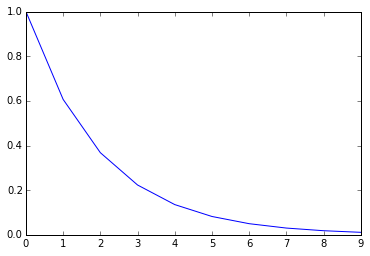

In [117]:
plt.plot(np.exp(-0.5 * np.arange(10)))

In [64]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

In [65]:
a

array([4, 4, 2, 2, 8, 7, 1, 2, 0, 6])

In [67]:
np.argsort(-a)

array([4, 5, 9, 0, 1, 2, 3, 7, 6, 8])

In [ ]:
np.argosrt()

In [61]:
a = None

In [63]:
if a is None:
    print("ywe")

ywe


# Slashdot data set

In [127]:
data = pd.read_csv("../datasets/Slashdot0811.txt", sep='\t', header=4)
data = data.as_matrix()

In [128]:
data.shape

(905467, 2)

In [129]:
slashdot, user_item = make_valid_data(data)

In [155]:
list_cf = [
    rankingmethod.PopRec(user_item),
    rankingmethod.CLiMF(user_item, K=10, reg=0.001, lrate=0.01, verbose=0, maxiter=10),
    rankingmethod.BPR_MF(user_item, K = 20, lrate=0.001, regIpos=0.1, 
                              regIneg=0.1, regU=0.1, maxiter=30, verbose=0 ),
    rankingmethod.iMF(user_item, K=10, lmbd=0.01, alpha=40, maxiter=30, verbose=0),
    rankingmethod.TFMAP(user_item, reg=0.001, lrate=0.01, maxiter=12)
    
]

list_measure = [
    rankingmeasure.get_prec_K,
    rankingmeasure.get_one_recal_K,
    rankingmeasure.get_MRR,
    rankingmeasure.get_AUC,
    rankingmeasure.get_NDCG,
    rankingmeasure.get_MAP
]

In [132]:
train, test, traintest = givenK_train_test(slashdot, 5)

In [133]:
poprec = rankingmethod.PopRec(user_item_slash)
poprec.fit(train)
top = poprec.get_list(0)[:3]
# all_measures(train, test, poprec, True, top)
all_measures(train, test, poprec, True)

precK 0.122225400458
1-call5 0.37528604118993136
MRR 0.273406086512
AUC 0.776325504811
NGDC 0.131158605935
MAP 0.227184043669


### givenk = 5

In [138]:
slash_ens = ensemble(list_cf, verbose=1)

In [139]:
slash_ens.fit(train)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [140]:
for cf in slash_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.1222254   0.37528604  0.13115861  0.22718404]
[ 0.12233982  0.37585812  0.13122573  0.22734037]
[ 0.12268307  0.37585812  0.1314579   0.227249  ]
[ 0.10420481  0.33495423  0.10975777  0.19563589]
[ 0.12062357  0.37628719  0.12923841  0.22546283]


In [141]:
top_ens = top_ensemble(slash_ens.list_cf, topK=100)

In [142]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.12402746,  0.39487986,  0.13112244,  0.23042843])

### givenk = 10

In [156]:
train, test, traintest = givenK_train_test(slashdot, 10)

In [157]:
slash_ens = ensemble(list_cf, verbose=1)
slash_ens.fit(train)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [158]:
poprec = rankingmethod.PopRec(user_item)
poprec.fit(train)
top = poprec.get_list(0)[:3]
#all_measures(train, test, poprec, True, top)
rankingmeasure.get_Kmetrics(train, test, poprec, True, K=5)

array([ 0.10918192,  0.3506865 ,  0.11928689,  0.21512741])

In [159]:
for cf in slash_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.10918192  0.3506865   0.11928689  0.21512741]
[ 0.10918192  0.3506865   0.11928689  0.21512741]
[ 0.10943936  0.35054348  0.11506516  0.2026143 ]
[ 0.13667048  0.40789474  0.14297494  0.24199681]
[ 0.10918192  0.3506865   0.11928901  0.21513456]


### Сравнение глазками

In [162]:
for cf in slash_ens.list_cf:
    print(type(cf).__name__)
    print(cf.get_list(0)[:15])

PopRec
[4668  394 2481  225 8848 4690 5043 3443  377  217 5390   34 2470 3444   46]
CLiMF
[4668  394 2481  225 8848 4690 5043 3443  377 5390   34  217 2470   46 2539]
BPR_MF
[ 394 2481 4668  225 8848  217 4690  377 5043 3443   46 5390 2470   34  403]
iMF
[2481 4668  143  151  205   15 4845   59 3369 3947 4979  186  400 5367 3083]
TFMAP
[4668  394 2481  225 8848 4690 5043 3443  377 3444  403  217 5390 5705 7450]


In [150]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.15946796,  0.51001144,  0.16663805,  0.29156159])

# старые эксперименты

In [ ]:
a = np.arange(10)
b = a[1:4]
print(a)
print(b)
b[2] = 100
a[1] = -a[1]
print(a)
print(b)

In [ ]:
tmp = mmread("../datasets/epinions_original/EP25_UPL5_test.mtx")
test = np.array(list(zip(tmp.row, tmp.col)))
tmp = mmread("../datasets/epinions_original/EP25_UPL5_train.mtx")
train = np.array(list(zip(tmp.row, tmp.col)))
user_item = [max(np.max(test[:,0]), np.max(train[:, 0])) + 1, max(np.max(test[:,1]), np.max(train[:,1])) + 1]

In [ ]:
train = create_listarray(train)
test  = create_listarray(test)

In [ ]:
create_csr(train, user_item, '../pyCLiMF-master/good_train.pickle')
create_csr(test, user_item, '../pyCLiMF-master/good_test.pickle')

In [ ]:
randomrec = rankingmethod.RandomRec(user_item)
randomrec.fit(train)
all_measures(train, test, randomrec, False)

In [ ]:
poprec = rankingmethod.PopRec(user_item)
poprec.fit(train)
top = poprec.get_list(0)[:3]
# all_measures(train, test, poprec, True, top)
# all_measures(train, test, poprec, True)

In [ ]:
rankingmeasure.get_AUC(train, test, poprec, True, K=user_item[1])

In [ ]:
rankingmeasure.get_NDCG(train, test, poprec, True, K = 5)

In [ ]:
rankingmeasure.get_NDCG(train, test, poprec, True, K = 3)

In [ ]:
index_user = np.random.choice(len(train), 100, replace=False)


In [ ]:
orig_train = create_original_sample(train, index_user)
orig_test = create_original_sample(test, index_user)

In [ ]:
climf = rankingmethod.CLiMF(user_item, lrate = 0.0001, reg=0.001, maxiter=15, verbose=2)
climf.fit(train)

In [ ]:
rankingmeasure.get_MRR(train, test, climf, True)

In [ ]:
all_measures(train, test, climf, True, top)

In [ ]:
all_measures(train, test, climf, True)

In [ ]:
climf = rankingmethod.CLiMF(user_item, maxiter=40, lrate = 0.1, verbose=2)
climf.fit(train)


In [ ]:
all_measures(train, test, climf, False)

In [ ]:
all_measures(train, test, climf, True, top)

In [ ]:
list_reg = [0.001, 0.002, 0.005, 0.0005]
list_lrate = [0.05, 0.07, 0.1, 0.12, 0.15 ]
list_K = [10, 12, 15, 7, 5]
times_count = 3

for K, lrate, reg in itertools.product(list_K, list_lrate, list_reg):
    MRR = 0
    
    for t in range(times_count):
        climf = rankingmethod.CLiMF(user_item,K=K, reg=reg, lrate=lrate, verbose=0, maxiter=50)
        climf.fit(train)
        MRR += rankingmeasure.get_MRR(train, test, climf, skip_train=False)
    print("K", K, "lrate", lrate, "reg", reg, "MRR", MRR/times_count)
    sys.stdout.flush()

In [ ]:
bpr_mf = rankingmethod.BPR_MF(user_item, K = 20, lrate=0.001, regIpos=0.1, 
                              regIneg=0.1, regU=0.1, maxiter=30, verbose=2 )

In [ ]:
bpr_mf.fit(train)

In [ ]:
all_measures(train, test, bpr_mf, True)

In [ ]:
rankingmeasure.get_AUC(train, test, bpr_mf, True, K=user_item[1])

In [ ]:
rankingmeasure.get_NDCG(train, test, bpr_mf, True, K=5)

In [ ]:
imf = rankingmethod.iMF(user_item, K=20, lmbd=0.01, alpha=40, maxiter=30, verbose=2)

In [ ]:
imf.fit(train)

In [ ]:
all_measures(train, test, imf, True)

In [ ]:
all_measures(train, test, imf, True, top)

In [ ]:
all_measures(train, test, bpr_mf, True, top)

In [ ]:
all_measures(train, test, poprec, True)

In [ ]:
all_measures(train, test, poprec, True, top)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
a = np.array([False,False, True, True])
b = np.array([0,2,1,3])
print(roc_auc_score(a, b, average=None))

In [ ]:
(a == True).any()

In [ ]:
import random

In [ ]:
random.sample(range(10), 3)